## Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
from pathlib import Path

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sys.path.append('/home/k64835/Master-Thesis-SITS')

scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Evaluation/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Modeling/").resolve()
sys.path.append(str(scripts_path))

In [28]:
import pickle
import time
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
from sklearn.manifold import TSNE 
from model_scripts.feature_extraction import *
from model_scripts.executions import *
import torch.nn.functional as F
from Experimentation.expt_scripts.sugarcontent_data_processing import *
from Experimentation.expt_scripts.expt_plots import *
from sklearn.model_selection import train_test_split
from model_scripts.subpatch_extraction import *
from Experimentation.expt_scripts.regression import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.model_helper import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from model_scripts.clustering import *
from evaluation_scripts.evaluation_helper import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
import numpy as np
import config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

## Dataset Prep: Non-Temporal Images

### Load non-temporal images

Data: Extracted and Pre-processed Patches, with a single temporal image from September

Dimensions: (N, C, H, W) = (N, 10, 64, 64)

In [5]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train_nt, acquisition_dates_train_nt, patch_tensor_train_nt, visualisation_train_nt = preprocessing_pipeline.get_processed_non_temporal_data('train', 'b10')
field_numbers_eval_nt, acquisition_dates_eval_nt, patch_tensor_eval_nt, visualisation_eval_nt = preprocessing_pipeline.get_processed_non_temporal_data('eval', 'b10')
patch_tensor_train_nt.shape, patch_tensor_eval_nt.shape

(torch.Size([1228, 10, 64, 64]), torch.Size([48, 10, 64, 64]))

### Create Sub-Patches

In [6]:
train_subpatches_nt, train_subpatch_coords_nt = non_overlapping_sliding_window_non_temporal(patch_tensor_train_nt, field_numbers_train_nt, patch_size=config.subpatch_size)
eval_subpatches_nt, eval_subpatch_coords_nt = non_overlapping_sliding_window_non_temporal(patch_tensor_eval_nt, field_numbers_eval_nt, patch_size=config.subpatch_size)
train_subpatches_nt.shape, eval_subpatches_nt.shape

(torch.Size([33128, 10, 4, 4]), torch.Size([1197, 10, 4, 4]))

Get field numbers and co-ordinates as string

In [7]:
train_coord_dataloader = get_string_fielddata(train_subpatch_coords_nt)
eval_coord_dataloader = get_string_fielddata(eval_subpatch_coords_nt)
train_coord_dataloader[0]

'1167136.0_1167138.0_24_24'

### Split Unlabeled data into 'train' and 'test' and create  Data Loaders

In [8]:
train_subpatches_dl, test_subpatches, train_field_numbers, test_field_numbers = train_test_split(
    train_subpatches_nt, train_coord_dataloader, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train = create_data_loader(train_subpatches_dl, train_field_numbers, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test = create_data_loader(test_subpatches, test_field_numbers, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval = create_data_loader(eval_subpatches_nt, eval_coord_dataloader, batch_size=config.ae_batch_size, shuffle=False)

## Modeling: Conv2D for Non-Temporal Images

In [9]:
class Conv2DAutoencoder_NonTemporal(nn.Module):
    def __init__(self, in_channels, latent_size, patch_size):
        super(Conv2DAutoencoder_NonTemporal, self).__init__()

        # --- Encoder ---
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)

        # --- Decoder (Deconvolutions) ---
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # x shape: (B, C, H, W)
        b, c, h, w = x.shape

        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Latent Space ---
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        z = self.fc2(x)

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))
        x = x.view(b, 256, h, w)

        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)

        return z, x_reconstructed


## Results and Comparison

In [41]:
optimizer='Adam'
epochs = 50
momentum=0.9
lr = 0.001
channels = 10
timestamps = 7
vae_optimizer='Adam'
vae_lr = 0.0001
device = 'cuda'

In [42]:
model_names = ["2D_AE_NonTemporal"]
model_objs = [Conv2DAutoencoder_NonTemporal]  # Replace with your model constructors
train_loss = {}
test_loss = {}
metrics = {}

for name, obj in zip(model_names, model_objs):
    avg_train_loss, avg_test_loss, avg_metrics = train_model_multiple_runs_with_metrics(
        model_name=name,
        model_class=obj,
        dataloader_train=dataloader_train,
        dataloader_test=dataloader_test,
        dataloader_eval=dataloader_eval,
        channels=channels, 
        timestamps=timestamps,
        epochs=epochs,
        optimizer=optimizer,
        lr=lr,
        vae_lr=vae_lr,
        vae_optimizer=vae_optimizer,
        momentum=momentum,
        device=device,
        config=config,
        output_dir=config.results_json_path,
        non_temp=True
    )
    train_loss[name] = avg_test_loss
    test_loss[name] = avg_test_loss
    metrics[name] = avg_metrics
    print("Model ",name," trained")


Model  2D_AE_NonTemporal  trained


In [43]:
model_names = ['2D_AE_NonTemporal', '3D_AE_temporal_addition']
df_loss, df_accuracy, df_recall = compile_results_table_with_metrics(model_names, output_dir=config.results_json_path)

In [44]:
df_accuracy

,Model,Accuracy Run 1,Accuracy Run 2,Accuracy Run 3,Accuracy Avg
0,2D_AE_NonTemporal,60.66,59.02,65.57,61.75
1,3D_AE_temporal_addition,68.85,68.85,68.85,68.85


In [45]:
df_recall

,Model,Recall Run 1,Recall Run 2,Recall Run 3,Recall Avg
0,2D_AE_NonTemporal,94.29,97.14,88.57,93.333333
1,3D_AE_temporal_addition,82.86,82.86,77.14,80.953333


In [46]:
df_loss

,Model,Loss Run 1,Loss Run 2,Loss Run 3,Loss Avg
0,2D_AE_NonTemporal,0.000051,0.000059,0.000052,0.000054
1,3D_AE_temporal_addition,0.000107,0.000095,0.000110,0.000104


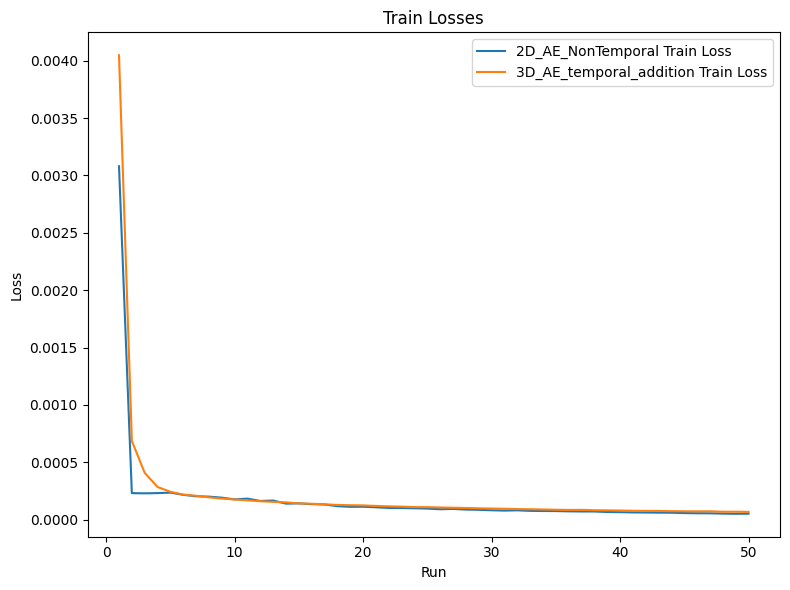

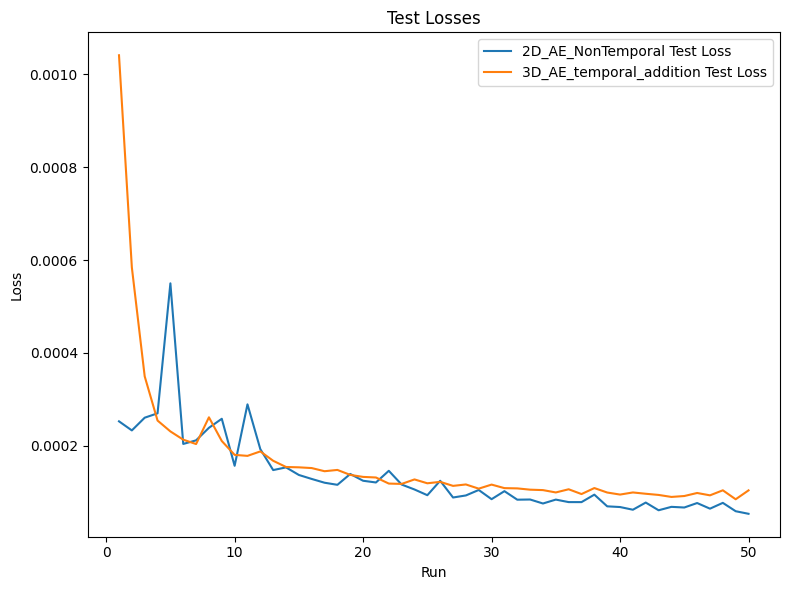

In [62]:
train_loss, test_loss = load_avg_losses(model_names, output_dir='/home/k64835/Master-Thesis-SITS/Modeling/Results')
plot_losses_ae(train_loss, test_loss)